## The Data

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv 

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered 

For more information about this data set, please visit [this link](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

In this project, we will try to predict the total number of bikes people rented in a given hour. We will predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we will create a few different machine learning models and evaluate their performance.

In [2]:
import pandas as pd
#Use the pandas library to read hour.csv into the dataframe bike_rentals.
bike_rentals = pd.read_csv("Bike-Sharing-Dataset\hour.csv")
#Print out the first few rows of bike_rentals and take a look at the data.
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

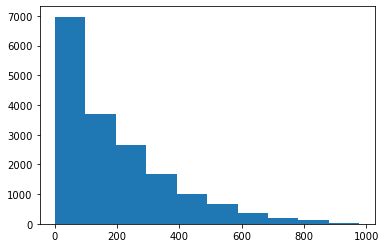

In [3]:
import matplotlib.pyplot as plt

#Make a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals.
plt.hist(bike_rentals["cnt"])

In [4]:
#Use the corr method on the bike_rentals dataframe to explore how each column is correlated with cnt.
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Calculating Features

We will calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

We will introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night.

In [6]:
'''
Write a function called assign_label that takes in a numeric value for an hour, and returns:
    * 1 if the hour is from 6 to 12
    * 2 if the hour is from 12 to 18
    * 3 if the hour is from 18 to 24
    * 4 if the hour is from 0 to 6

'''
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 
    
#Use the apply method on series objects to apply the function to each item in the hr column
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

## Splitting The Data: Train And Test Sets

In [7]:
#Select 80% of the rows in bike_rentals to be part of the training set using the sample method on bike_rentals. 
train = bike_rentals.sample(frac=.8)

#Select the rows that are in bike_rentals but not in train to be in the testing set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Performance Evaluation of Our ML algorithms

First, we need to pick an error metric you want to use to evaluate the performance of the machine learning algorithms.

The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

## Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np

#Create a list of predictor columns to use in training and predictions
predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

#Use the LinearRegression class from sklearn to train a machine learning algorithm on train
L_reg = LinearRegression()

#Make predictions using the LinearRegression class on test.
L_reg.fit(train[predictors], train["cnt"])

#Calculate the error between the predictions and the actual values
predictions = L_reg.predict(test[predictors])

error_L = np.mean((predictions - test["cnt"]) ** 2)

error_L

17566.992859386683

**The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.**

## Decision Trees

Now let's apply the decision tree algorithm. We'll be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability: small changes in the input data can result in a very different output model.

In [12]:
from sklearn.tree import DecisionTreeRegressor

#Use the DecisionTreeRegressor class to fit a decision tree algorithm to the train data
reg = DecisionTreeRegressor(min_samples_leaf=5)

reg.fit(train[predictors], train["cnt"])

#Make predictions using the DecisionTreeRegressor class on test
predictions = reg.predict(test[predictors])
#Calculate the error between the predictions and the actual values.
error_D = np.mean((predictions - test["cnt"]) ** 2)

In [333]:
#Experiment with various parameters of the DecisionTreeRegressor class
#, including min_samples_leaf, to see if it changes the error.
reg = DecisionTreeRegressor(min_samples_leaf=10, max_depth=19,min_samples_split=14)

reg.fit(train[predictors], train["cnt"])

predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

2602.168439246021

**By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.**

## Random Forest

Now we'll apply the random forest algorithm, which improves on the decision tree algorithm. 

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [360]:
from sklearn.ensemble import RandomForestRegressor
#Use the RandomForestRegressor class to fit a random forest algorithm to the train data
reg = RandomForestRegressor(min_samples_leaf=4,min_samples_split=5)
reg.fit(train[predictors], train["cnt"])

#Make predictions using the RandomForestRegressor class on test
predictions = reg.predict(test[predictors])

#Calculate the error between the predictions and the actual values.
error_R = np.mean((predictions - test["cnt"]) ** 2)
error_R

1699.8021154200676

**By removing some of the sources of overfitting, the random forest accuracy is better than the decision tree accuracy. Hence it's improved.**

## Recommendations

Here are some potential next steps:

    Calculate additional features, such as:
        An index combining temperature, humidity, and wind speed
    Try predicting casual and registered instead of cnt.
